In [1]:
from bs4 import BeautifulSoup as soup
import requests 
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

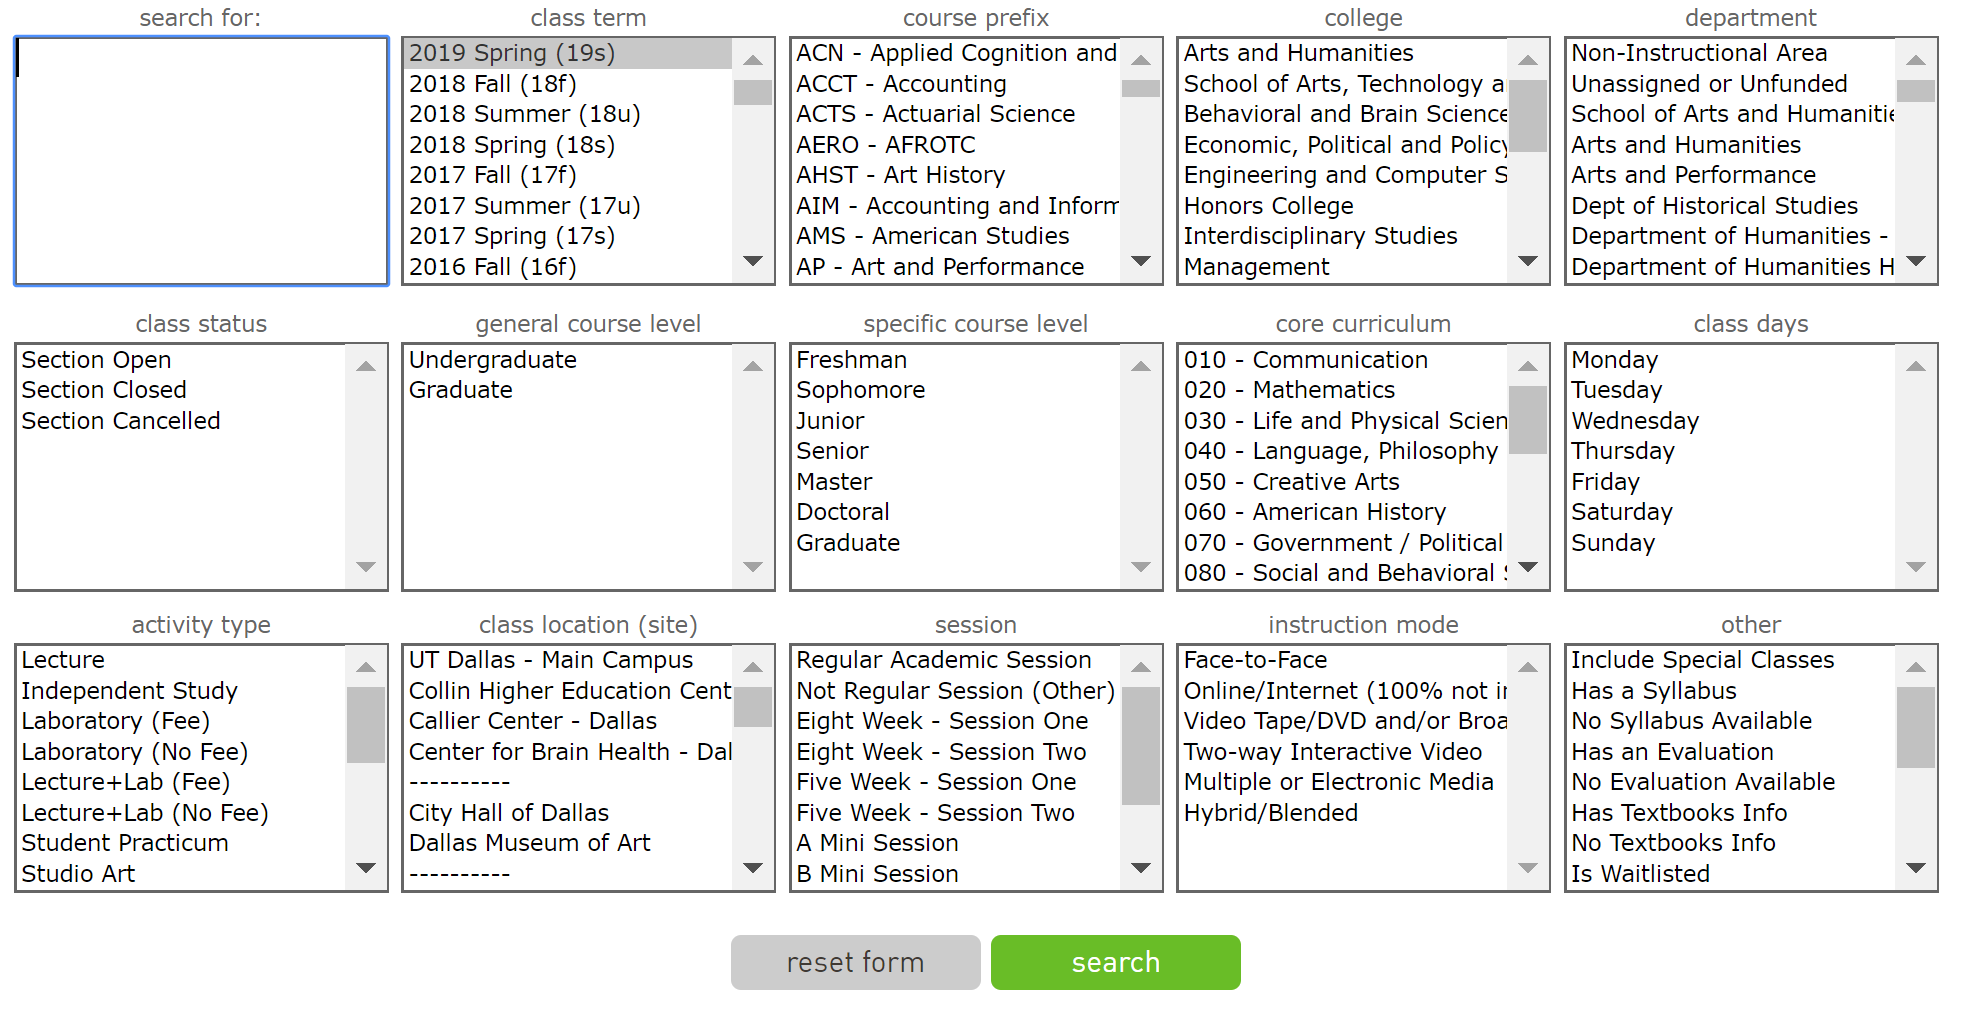

In [10]:
#Coursebook Scraper
#14 filters
#Process: all data can be obtained by querying based on diffrent filters
#every applied filter generates a url, so get every possible url(query)
#get the <table></table> from the website and add it to a dataframe
#use dataframe to find any open rooms

#Class term, only need most recent terms
#values = ['term_19s', 'term_18f']

#Course Prefix
#coursePrefix = ['cp_acn','cp_acct','']

#The picture below shows all the possible filters that can be used
#Each filter has a keyword which is used to generate a url and retrive data from UTD's DB, POST request

from IPython.core.display import Image, display
display(Image('search_filters.PNG', width=700, unconfined=True))

In [29]:
#just downloaded the raw html, and parse through it, b/c it wasn't working with requests
data = soup(open('coursebook.html'), 'html.parser')


#acquiring the filter tags is a one-time task so no need to make functions for it

#get all the text from the html tags
vals = []
for i in data.findAll('span', class_='html-attribute-value'):
    vals.append(i.text) 
    
    
#returns all the keywords(query terms) for each filter
info = []
for i in range(len(vals)):
    if(vals[i] == 'multiple'):
        keyword_store = []
        j = i+1
        while(vals[j] != 'selectlist-block' and j < len(vals)-1 and vals[j] !='clear: both;'):
            keyword_store.append(vals[j])
            j += 1
        info.append(keyword_store)
        
#assign keywords to the filters, so query can be constructed
filters = ['class_term', 'course_prefix', 'college', 
           'department', 'class_status', 'g_course_level',
           's_course_level','core_curr','class_days',
           'activity_type','class_location','session','instruction_mode',
           'other']

#dict for the filters, to store the query keywords
filt_kw = {i:[] for i in filters}
keys = list(filt_kw.keys())
for i in range(len(info)):
    filt_kw[keys[i]] = info[i] #remove dashes

In [30]:
#class term: only need 18_f, term_19s
#class status: section open, section close
#class location: UT Dallas - Main Campus
#instruction mode: face-to-face, hybrid

#if no results are returned, then try catch will be used

#Gathering data process, go through every combination of college and day
#this should give us most of the data needed to figure out which rooms are open


#filter options that don't need to be taken into account

filt_kw['activity_type'].remove('_')
filt_kw['activity_type'].remove('activitytype_mst')
filt_kw['activity_type'].remove('activitytype_dsr')
filt_kw['activity_type'].remove('activitytype_res')
filt_kw['activity_type'].remove('activitytype_slf')
filt_kw['activity_type'].remove('activitytype_sth')
filt_kw['activity_type'].remove('activitytype_cln')


filt_kw['class_days'].remove('clear') #remove the 'clear'
filt_kw['college'].remove('_') #remove the dash

#now lets do query construction
#we try all the options for 'college', 'class_days', and 'activity_type'
base_url = 'http://coursebook.utdallas.edu'
all_urls = []
for i in range(len(filt_kw['college'])):
    for j in range(len(filt_kw['class_days'])):
        for k in range(len(filt_kw['activity_type'])):
            custom_url = base_url + '/term_19s/' + filt_kw['college'][i] + '/sectionstatus_o/sectionstatus_c/' + filt_kw['class_days'][j] + '/'+ filt_kw['activity_type'][k] + '/site_utdm/instructionmode_1/instructionmode_6?#searchresults'
            #term_19s for this semester
            all_urls.append(custom_url)

print('Number of queries to run: ' + str(len(all_urls)))

Number of queries to run: 1190


In [17]:
def make_index_0(df):
    '''resets index'''
    df.reset_index(inplace=True)
    df.drop(['index'],axis=1,inplace=True)

In [18]:
def removing_certain_data(data):
    make_index_0(data) 
    #have to reset_index before starting
    #check for drop cases in Schedule & Location
    for i in range(len(data)):
        item = data['Schedule &Location'][i]
        if(item.find('tbd') != -1):
            data.drop([i], inplace=True)
            
    make_index_0(data)#reset_index again

In [19]:
def clean_data(df):
    '''clean the html table, delete unneeded cols, and drops rows that are empty'''
    df.drop(['TermStatus','Fill','Action(s)'],
         axis=1, inplace=True)
    df.dropna(inplace=True)
    removing_certain_data(df)

In [20]:
def day_time_loc(sch_loc_str):
    '''break a string from Schedule & Location col into three'''
    if(sch_loc_str == ''): #if its an empty string
        return('', '', '')
    
    b1 = 0 #breakpoints
    b2 = 0
    for i in range(len(sch_loc_str)):
        if(sch_loc_str[i].isdigit()):
            b1 = i
            break
    for i in range(b1, len(sch_loc_str)):
        if(sch_loc_str[i-2] == 'm' and sch_loc_str[i].isupper()):
            b2 = i
            break
    return(sch_loc_str[:b1], sch_loc_str[b1:b2], sch_loc_str[b2:])

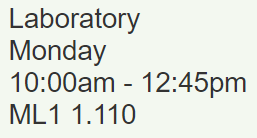

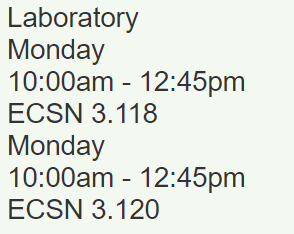

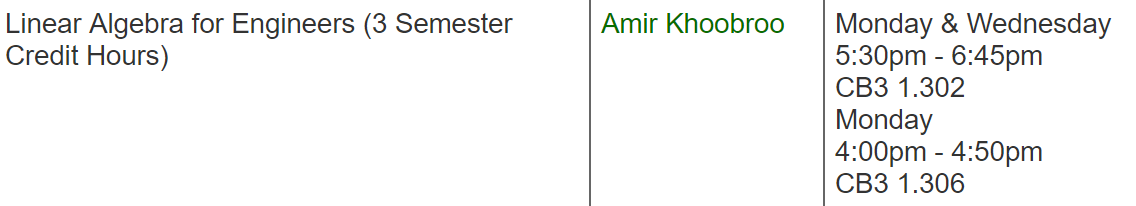

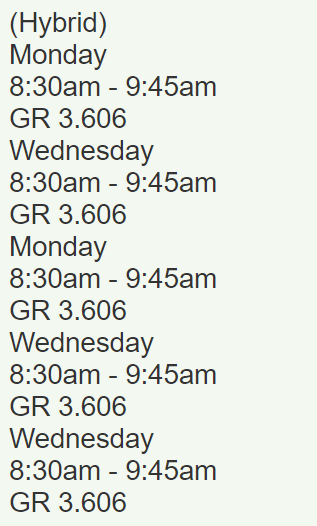

In [21]:
#Doesn't account for labs, so lets get all the labs and add them to the data
from IPython.core.display import Image, display
x = Image('short_lab_des.PNG', width=100, unconfined=True)
y = Image('long_des_lab.PNG', width=100, unconfined=True)
z = Image('combined.PNG', width=400)
w = Image('longer_des.PNG', width=150)
display(x,y, z, w)
#so we got 4 cases

In [25]:
#certain strings will be removed b/c they preceed the locations info., so we have get rid of them
def filter_loc_string(loc_string):
    '''filters out certain keywords that come before location info
       Keywords: Laboratory, Studio, Studio Ensemble...'''
    filter_loc_types = ['Laboratory', 'Studio', 'Studio Ensemble', 'Independent Study', 'Seminar', '(Hybrid)', 'Internship']
    for i in filter_loc_types:
        if(loc_string.find(i) != -1):
            loc_string = loc_string.split(i)[1]
            break
        
    return loc_string
    
def short_des(loc_string):
    '''used to deal with short descriptions
       its a short des => if it has 1 dash'''
    return filter_loc_string(loc_string)

def long_des(loc_string):
    '''returns the split point for the string for long descriptions
       its a long des => if it has 2 dashes'''
    loc_string = filter_loc_string(loc_string)
    ind = 0
    for i in range(0,len(loc_string)-2):
        if loc_string[i].isdigit() and loc_string[i+2].isupper():
            ind = i+2
            break
    return [loc_string[:ind], loc_string[ind:]]

In [26]:
def process_table(df):
    clean_data(df) #drops na, certain cols, resets index to zero
    
    df['Days'] = '' #add in the location cols
    df['Time'] = '' 
    df['Location'] = ''
    
    len_at_start = len(df)
    j = 0
    for i in range(len(df)):
        row = df.iloc[i]
        row_sch_loc = row['Schedule &Location']
        if(row_sch_loc.count('-') == 1): #if there is only one dash, meaning only one location info.
            temp = short_des(row_sch_loc)
            day, time, loc = day_time_loc(temp)
            data = list(row)[:-3] + [day, time, loc]
            df.loc[i] = data
        if(row_sch_loc.count('-') == 2): #if there is only two dashes, meaning only two location info.
            temp = long_des(row_sch_loc)
            day, time, loc = day_time_loc(temp[0]) #the first part of the string
            data = list(row)[:-3] + [day, time, loc]
            df.loc[i] = data
            day, time, loc = day_time_loc(temp[1]) #the second part
            data = list(row)[:-3] + [day, time, loc]
            df.loc[len_at_start+j] = data
            j += 1
        if(row_sch_loc.count('-') > 2): #for school_things?? with more than 2 dashes
            if(row_sch_loc.find('Examination') != -1):
                pass
            else:
                #we can apply long_des twice to get the first two locations, this heuristic should work 
                #since for longer description, the first two lines are unique then locs are repeated(in the images above)
                temp = long_des(row_sch_loc) #this gives us the first location
                day, time, loc = day_time_loc(temp[0]) #save it to the table
                data = list(row)[:-3] + [day, time, loc]
                df.loc[i] = data
                
                day, time, loc = day_time_loc(long_des(temp[1])[0]) #this gives us the second location
                data = list(row)[:-3] + [day, time, loc] #save it to the table
                df.loc[len_at_start+j] = data
                j += 1
        
    df = df.sort_values('Class SectionClass Number').copy() #sort it by class number
    make_index_0(df) #reset the index 
    
    return df

In [28]:
def process_url(url):
    '''will be used to process the url(query)'''
    try:
        temp_data = pd.read_html(url)[1]
        if(len(temp_data) >= 299): 
            #to catch any queries that return the max amount of results b/c coursebook returns table of max size 300 
            print('Large Table: ' + url)
        process_table(temp_data)
        return temp_data
    except:
        return 'Not Found ' + url

In [35]:
##this cell block will be used to run the queries, get the data, filter it, and save it
# from multiprocessing.dummy import Pool as ThreadPool #will be used for threading
# from tqdm import tqdm_notebook as tqdm #will be used to show where the loop is at

# print('Total Queries to run: ' + str(len(all_urls)))

# tot_data = []
# for i in tqdm(range(0, len(all_urls), 20)):
#     pool = ThreadPool(10)
#     batch_data = pool.map(process_url, all_urls[i-20: i]) #parallel map
#     pool.close()
#     pool.join()
#     tot_data += batch_data
    
# tot_data = [i for i in tot_data if type(i) != str] #some queries didn't return tables, but strings, so we get rid of them
# tot_data = pd.concat(tot_data) #concat all the tables
# make_index_0(tot_data)
# tot_data.drop_duplicates(inplace=True)

# #len(pd.read_parquet('main_data')) #this is what we had before, 2115
# #len(tot_data) #prints 5440, drop duplicates => we get 3619

# def save_data(df, filename='main_data'): #save the data to parquet form
#     pd.DataFrame.to_parquet(df, fname=filename)
    
# save_data(tot_data, '19_s_courseData') #save the data so we don't have to query over again


#### The methods below are used to analyze the data so we can generate utility 

In [3]:
#tot_data = pd.read_parquet('18_f_courseData') #reads in table with scraped data
#tot_data = pd.read_parquet('19_s_courseData') #reads in table with scraped data
tot_data = pd.read_csv('19_s_courseData_csv') 

In [4]:
tot_data.drop(tot_data[tot_data["Time"] == ''].index, inplace=True) #get rid of data with no value

In [99]:
#tot_data.to_csv('18_f_courseData_csv')
#tot_data.to_csv('19_s_courseData_csv')

In [6]:
def remove_lead_trail_white_space(some_string):
    return some_string.lstrip().rstrip()

#remove white space b/c 'build_name ' is not same as 'build_name', extra space at the end causes conflict
tot_data['Location'] = list(map(remove_lead_trail_white_space, tot_data['Location'])) #strips leading and trailing white space, set operations work
tot_data['Time'] = list(map(remove_lead_trail_white_space, tot_data['Time'])) 
tot_data['Days'] = list(map(remove_lead_trail_white_space, tot_data['Days']))
tot_data['Class Name'] = list(map(lambda x: remove_lead_trail_white_space(x.split('(')[0]), tot_data['Class Title']))

In [7]:
#These variables are mainly used in the web app, they just help organize info.

building_names = ['Activity Center', 'Administration', 'Arts and Humanities 1', 'Arts and Humanities 2','Edith O’Donnell Arts and Technology Building','Lloyd V. Berkner Hall','Bioengineering and Sciences Building','Classroom Building','Classroom Building 1', 'Classroom Building 2', 'Classroom Building 3', 'Callier Center Richardson', 'Callier Center Richardson Addition', 'Engineering and Computer Science North', 'Engineering and Computer Science South', 'Engineering and Computer Science West', 'Founders North', 'Founders Building', 'Cecil H. Green Hall','Karl Hoblitzelle Hall', 'Erik Jonsson Academic Center', 'Naveen Jindal School of Management', 'LLC', 'Eugene McDermott Library', 'Modular Lab 1' ,'Physics Building', 'Research and Operations Center', 'Research and Operations Center West', 'Science Learning Center', 'Synergy Park North','Student Services Building (Admissions)', 'Theatre']
#name all buildings used (Activity Center, Founders, ...)
all_buildings = list(set([i.split()[0] for i in tot_data['Location'].unique()]))
#all the buildings tags (JSOM, ATC, FO...)

lab_locs = set()
for i in range(len(tot_data)):
    temp = tot_data.iloc[i]
    if(temp['Class Title'].find('Lab') != -1 or temp['Class Title'].find('lab') != -1):
        lab_locs.add(temp['Location'])
#used to find all the classes that are labs, will be used to filter out labs since most of the times there are locked

building_tags = {x:y for x,y in zip(sorted(all_buildings),building_names)} #dict that ties building tag to name{'FO':'Founders'..}
all_possible_locs = set(tot_data['Location']) #get all possible rooms

loc_tags = {}
for i in all_possible_locs: #loop used to assign room number to building name {'FO 1.315': 'Founders'}
    loc_tags[i] = building_tags[i.split()[0]]
loc_tags = dict(sorted(loc_tags.items()))

In [8]:
def does_it_fall_between(time_range, time1, time2):
    '''Given a time range, start time, and end time => check to see if there is overlap'''
    p1 = pd.to_datetime(time_range.split()[0]) #start of range
    p2 = pd.to_datetime(time_range.split()[2]) #end of range
    time1 = pd.to_datetime(time1) #start of user time range
    time2 = pd.to_datetime(time2) #end of user time range
    return (p1 <= time1 and p2 >= time1) or (p1 <= time2 and p2 >= time2) or (p1 >= time1 and p2 <= time2) or (p1 <= time1 and p2 >= time2) 

In [137]:
def get_open_locs(day, time_start, time_end, loc_pref=all_buildings, df=tot_data, show_labs=False): #loc_preference defaults to all
    ''' find all open locations given a day(day) and time(time)
        day: what day it is
        time: what time it is
        => day = monday, time = 3:30pm
        => first find all classes that are held on monday
        => for all classes on monday, find locations of classes that intersect with the time given(3:30pm)
        => all_locs - occupied_locs = free_locs
        => return free_locs
        => labs are turned off by default meaning open lab locations will not be shown since there are closed most of the times'''
    data = df.copy()
    import functools
    inds = list(map(lambda x: True if x.find(day) != -1 else False, data['Days']))
    classes_that_intersect = list(map(functools.partial(does_it_fall_between, time1=time_start, time2=time_end), data[inds]['Time']))
    if(show_labs):
        free_locs = list(set(data['Location']) - set(data[inds][classes_that_intersect]['Location']) - lab_locs)
        #we subtract the lab_locs set so lab locations are not shown
    else:
        free_locs = list(set(data['Location']) - set(data[inds][classes_that_intersect]['Location']))
        
    
    if(type(loc_pref) == str):
        loc_pref = [loc_pref]
    
    sorted_by_locs_nums = sorted([i for i in free_locs if i.split()[0] in loc_pref])
    return sorted_by_locs_nums

In [138]:
get_open_locs('Monday', '8:45am', '9:45am', 'ECSW')

['ECSW 1.130', 'ECSW 1.315']

In [11]:
def classes_given_loc_day(locs, day, data=tot_data):
    '''Find all classes given location and day'''
    info = []
    for loc in locs:
        inds = list(map(lambda x: True if x.find(day) != -1 else False, data['Days']))
        temp = tot_data.iloc[inds][tot_data['Location'] == loc]
        temp['Sort_time'] = temp['Time'].apply(lambda x: pd.to_datetime(x.split()[0]))
        temp = temp.sort_values(by=['Sort_time']).drop(['Sort_time'], axis=1).drop(['Class SectionClass Number', 'Schedule &Location'], axis=1).drop_duplicates()
        info.append(temp)
    
    return info

In [12]:
all_profs = sorted(set(tot_data['Instructor(s)'])) #all profs 
def get_prof_data(prof_list, data=tot_data):
    '''Gets all the classes taught by the given profs.'''
    prof_data_list = []
    for i in prof_list:
        temp = tot_data[data['Instructor(s)'] == i].drop(['Class Title', 'Instructor(s)','Schedule &Location'], axis=1).drop_duplicates()
        prof_data_list.append(temp)
    return prof_data_list

In [13]:
def get_time_slots(class_sch, min_gap=0):
    '''Given the class timings, it will find and calculate the open times
       min_gap will be used to filter out time_slot less than min_gap
    '''
    if(len(class_sch)==0):
        return 'No Classes'
    
    times_list = [i for i in class_sch['Time']] #gets the class timings
    if(len(times_list) == 1): #if only one class happens 
        return[('Before', remove_lead_trail_white_space(times_list[0].split('-')[0])),
              ('After', remove_lead_trail_white_space(times_list[0].split('-')[1]))]
    
    gap_list = [] #keeps track of the open times
    gap_list.append(('Before', remove_lead_trail_white_space(times_list[0].split('-')[0])))

    p2 = remove_lead_trail_white_space(times_list[0].split('-')[0]) 
    #used to filter out classes with diffrent names but with the same timings 
    for i in range(len(times_list)-1):
        if(remove_lead_trail_white_space(times_list[i+1].split('-')[0]) != p2):
            p1 = remove_lead_trail_white_space(times_list[i].split('-')[1])
            p2 = remove_lead_trail_white_space(times_list[i+1].split('-')[0])
            if(((pd.to_datetime(p2) - pd.to_datetime(p1)).seconds // 60) >= min_gap):
                time_gap_hrs = (pd.to_datetime(p2) - pd.to_datetime(p1)).seconds // 3600 #get time gap in hrs
                time_gap_mins = ((pd.to_datetime(p2) - pd.to_datetime(p1)).seconds // 60)%60 #gets the remaining time gap in minutes
                
                gap_list.append((p1,p2, time_gap_hrs, time_gap_mins))
            
    gap_list.append(('After', remove_lead_trail_white_space(times_list[-1].split('-')[1])))
    
    return gap_list

In [14]:
def process_oneClassTime(timeSlot):
    return timeSlot[0][0] + ' ' + timeSlot[0][1] + ' and ' + timeSlot[1][0] + ' ' + timeSlot[1][1]

In [15]:
def processMultiClass(timeSlots):
    processed = []
    processed.append(timeSlots[0][0] + ' ' + timeSlots[0][1])
    for i in timeSlots[1:-1]:
        if(i[2] != 0):
            temp = i[0] + ' to ' + i[1] + ' (' + str(i[2]) + 'hr and ' + str(i[3]) + ' min)'
        else:
            temp = i[0] + ' to ' + i[1] + ' (' + str(i[3]) + ' min)'
        
        processed.append(temp)
    processed.append(timeSlots[-1][0] + ' ' + timeSlots[-1][1])
    return processed

In [133]:
def get_timeSlots_given_loc(locations, day, min_time):
    '''Returns all timeslots proccesed given locations, day, and min_time
       Format: for each location => [no_classes_String, {oneClassDict}, {multiClassDict}]'''
    
    time_slot_data_by_loc = []
    for i in locations:
        no_class_locs = []
        one_class_locs = []
        multi_class_locs = []

        one_class_times = []
        multi_class_times = []

        all_class_locs = set(filter(lambda x:True if x.split()[0] == i else False, tot_data['Location']))
        #line below removes all lab_locs so they are not considered for empty rooms
        all_class_locs = sorted(all_class_locs - lab_locs)
        for j in all_class_locs:
            temp = get_time_slots(classes_given_loc_day([j],day)[0], min_gap=min_time)
            if(type(temp) == str): #if its no classes
                no_class_locs.append(j)
            elif(len(temp) == 2): #if its one class location
                one_class_locs.append(j)
                one_class_times.append(process_oneClassTime(temp))
            else: #if its multi class location
                multi_class_locs.append(j)
                multi_class_times.append(processMultiClass(temp))

        oneClassDict = dict(zip(one_class_locs,one_class_times))
        multiClassDict = dict(zip(multi_class_locs, multi_class_times))
        time_slot_data_by_loc.append([', '.join(no_class_locs), oneClassDict, multiClassDict])
        
    return time_slot_data_by_loc

In [17]:
tot_data['Course Number'] = list(map(lambda x: x.split('.')[0] + '.' + x.split('.')[1][:3], tot_data['Class SectionClass Number']))
tot_data['Course pre'] = list(map(lambda x: x.split('.')[0], tot_data['Class SectionClass Number']))

In [18]:
def get_class_data(class_list, course_name_list, data=tot_data):
    '''Gets all the class info'''
    if(len(class_list) == 0 and len(course_name_list) == 0):
        return 'Nothing selected'
    
    class_data_list = []
    if(len(class_list) != 0):
        for i in class_list:
            temp = data[data['Course pre'] == i].drop(['Class Title', 'Schedule &Location', 'Course pre'], axis=1).drop_duplicates()
            class_data_list.append(temp)
            
    if(len(course_name_list) != 0):
        for i in course_name_list:
            temp = data[data['Class Name'] == i].drop(['Class Title', 'Schedule &Location', 'Course pre'], axis=1).drop_duplicates()
            class_data_list.append(temp)
        
    return class_data_list
    
    

#### The code below is used to gather urls from RateMyProfessor and UTDGrades

In [19]:
rmp_base_p1 = 'http://www.google.com/search?rlz=1C1CHBF_enUS813US813&ei=1MsTXOGuBorytAW06ZWIAw&q='
rmp_base_p2 = '+at+University+of+Texas+at+Dallas+site%3Aratemyprofessors.com'

In [20]:
rmp_url_p1 = 'www.ratemyprofessors.com/ShowRatings.jsp?tid='

###### Scraping google for the RateMyProfessor links was a bit hard because I kept getting blocked with a 503 error. So, to bypass that I tried rotating IP addresses and spoofing User Agents. The code below shows how to do that. However, none of those methods were successful, so I just changed networks(WiFi network) and that worked. The downside was that I could only scrape ~250 professor urls before I got a 503 error. So, then I would have to change networks again. 

In [244]:
#Goal: need to scrape for all rate my prof IDs from google

#I could have just scraped RateMyProf but I wanted to figure out scrape google without getting banned b/c it will help with
#another project

#Scraper using bs4 and urllib => got a 503 error: forbidden access, found out I was automating
#Stopped at 137th prof => total # of profs is 1196
# all_profs = list(set(tot_data['Instructor(s)']))
# prof_rmp_id = {} #maps prof name to their rmp id

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup

# for i in all_profs[1:]:
#     rmp_base_url = rmp_base_p1 + '+'.join(i.split()) + rmp_base_p2
#     resp = Request(rmp_base_url, headers={'User-Agent': 'Mozilla/5.0'}) 
#     #need to add header b/c the site has sever security(mod_security) which blocks spider/bots from scraping
#     soup = BeautifulSoup(urlopen(resp))
#     #urlopen(resp) => gives http response
#     #BeautifulSoup => turns the response into readable data
#     try:
#         prof_id = soup.find('cite').text.split('=')[1] #extract the prof id from the rate my prof url
#         prof_rmp_id[i] = 'http://www.ratemyprofessors.com/ShowRatings.jsp?tid=' + prof_id #add it to the dict
#     except AttributeError:
#         prof_rmp_id[i] = 'Not found'




# Scraper using selenium => got hit with a recaptcha
# Stopped at 46th prof => total # of profs is 1196
# from selenium import webdriver
# driver = webdriver.Chrome('C:\\Users\\Mithil Viradia\\Downloads\\chromedriver_win32\\chromedriver.exe')
# prof_rmp_dict = {}
# for i in all_profs[391:400]:
#     rmp_base_url = rmp_base_p1 + '+'.join(i.split()) + rmp_base_p2
#     driver.get(rmp_base_url)
#     time.sleep(2)
#     try:
#         rmp_id = driver.find_elements_by_tag_name('cite')[0].text.split('=')[1]
#         prof_rmp_dict[i] = 'http://www.ratemyprofessors.com/ShowRatings.jsp?tid=' + rmp_id
#     except IndexError:
#         prof_rmp_dict[i] = 'Not found'




In [ ]:
#The next few code blocks are just me trying to figure out rotating IPs and User agents

#Helpful link
#https://www.scrapehero.com/how-to-rotate-proxies-and-ip-addresses-using-python-3/

import requests
#proxy => a computer that acts as middleman between an endpoint device and user requesting some service
#3 types of proxy
#Transparent Proxy - server between your computer and the internet, just redirects requests w/o modification
#sends with it your real IP address in HTTP_X_FORWARDED_FOR header
#sends with it HTTP_VIA header which can flags that you are using proxy

#Anonymous Proxy - does not send your real IP address, but HTTP_VIA header is sent
#so the server knows your are proxy user, good for privacy 

#Elite Proxy - sends REMOTE_ADDR header with other headers being empty, makes it
#seems like your a regular user



url = 'https://httpbin.org/ip'
proxies = {
    'http': 'http://192.241.129.232:80',
    'https': 'http://192.241.129.232:80',
}

response = requests.get(url, proxies=proxies)
print('With proxy: ', response.json())
response = requests.get(url)
print('Without proxy: ' , response.json())

#---------------------------------------------------------------------------


from itertools import cycle
import traceback

#https://free-proxy-list.net/ =>found proxies from here, https YES, look for elite proxy
#Makes getting banned from scraping harder b/c requests can be made from diffrent IP addresses
proxies = ['91.200.160.105:30511','192.241.129.232:80','125.24.156.233:34224', '128.199.217.204:8080','82.147.120.40:46034','202.166.205.78:58431', '93.33.234.116:56793', '80.188.239.106:39271','54.39.144.247:9090', '202.84.77.78:60322']
proxy_pool = cycle(proxies) 
#will cycle through the proxy list, so we end up using diffrent middlemen

url = 'https://httpbin.org/ip'
for i in range(1,11):
    proxy = next(proxy_pool) #gets the next proxy from the cycle(pool)
    print('Request #%d'%i)
    try:
        response = requests.get(url,proxies={'http':proxy, 'https':proxy})
        print(response.json())
    except:
        #if there is a connection error
        print('Skipping. Connection error')
        

In [216]:
#Spoof User Agents
#User agent - a string that browser sends to each website you vist
#contains stuff like app type, OS, software version, ...
#Web servers then analyze this info. to figure out capabilities of your computer
#and return a page that is optimized to your computer(page's perfomance and display)
#Example user agent string:
#User-Agent: Mozilla/<version> (<system-information>) <platform> (<platform-details>) <extensions>

#List of user-agents
#https://developers.whatismybrowser.com/useragents/explore/


import requests
url = 'https://httpbin.org/user-agent'
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
response = requests.get(url, headers={'User-Agent': user_agent})
html = response.content
print('With user-agent spoof: ', html)
response = requests.get(url)
html = response.content
print('Without user-agent spoof: ', html)

With user-agent spoof:  b'{\n  "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36"\n}\n'
Without user-agent spoof:  b'{\n  "user-agent": "python-requests/2.18.4"\n}\n'


In [ ]:
# from fake_useragent import UserAgent
# import random
# ua = UserAgent()
# proxies = ['91.200.160.105:30511','192.241.129.232:80','125.24.156.233:34224', '128.199.217.204:8080','82.147.120.40:46034','202.166.205.78:58431', '93.33.234.116:56793', '80.188.239.106:39271','54.39.144.247:9090', '202.84.77.78:60322']
# #proxies_dict = [{'ip': i.split(':')[0], 'port': i.split(':')[1]} for i in proxies]

# def random_proxy():
#     return random.randint(0, len(proxies)-1)

# proxy_index = random_proxy()
# proxy = proxies[proxy_index]

# for n in range(1,100):
#     req = Request('http://icanhazip.com')
#     req.set_proxy(proxy, 'http')
    
#     if n%10 == 0:
#         proxy_index = random_proxy()
#         proxy = proxies[proxy_index]
        
#     try:
#         my_ip = urlopen(req).read().decode('utf8')
#         print('#' + str(n) + ':' + my_ip)
#     except:
#         del proxies[proxy_index]
#         proxy_index = random_proxy()
#         proxy = proxies[proxy_index]
#         print('Not working: ', proxies[proxy_index])



# fakeUserList = [ua.random for i in range(6)]
# proxies = ['195.182.152.238:38178','93.170.117.230:44000','5.58.208.112:61075', '128.199.217.204:8080','95.140.21.66:53281','186.1.32.16:55477', '177.53.221.89:58814']
# proxies_dict = [{'http': i, 'https': i} for i in proxies[:6]]
# from itertools import cycle
# proxy_pool = cycle(proxies_dict)
# user_pool = cycle(fakeUserList)

# for i in range(6):
#     try:
#         curr_user = next(user_pool)
#         curr_proxy = next(proxy_pool)
#         response = requests.get('https://httpbin.org/ip', headers={'User-Agent': curr_user}, proxies=curr_proxy)
#         print(curr_proxy, response.content)
#         response = requests.get('https://httpbin.org/user-agent', headers={'User-Agent': curr_user}, proxies=curr_proxy)
#         print(curr_user, response.content)
#     except ConnectionRefusedError:
#         print(curr_proxy)

from itertools import cycle
proxy_pool = cycle(proxies_dict)
user_pool = cycle(fakeUserList)

for i in range(6):
    try:
        curr_user = next(user_pool)
        curr_proxy = next(proxy_pool)
        response = requests.get('https://httpbin.org/ip', headers={'User-Agent': curr_user}, proxies=curr_proxy)
        print(curr_proxy, response.content)
        response = requests.get('https://httpbin.org/user-agent', headers={'User-Agent': curr_user}, proxies=curr_proxy)
        print(curr_user, response.content)
    except ConnectionRefusedError:
        print(curr_proxy)

In [72]:
prof_rmp_id = {} #dict to hold RMP urls for each prof

In [83]:
prof_remaining = sorted(set(all_profs) -  set(sorted(prof_rmp_id)))[1:] # ignore 1st element b/c its '-Staff-', not useful

In [ ]:
#have to run this loop multiple times b/c you get 503 error which is just google blocking you

import time
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
for i in prof_remaining:
    rmp_base_url = rmp_base_p1 + '+'.join(i.split()) + rmp_base_p2
    resp = Request(rmp_base_url, headers={'User-Agent': 'Mozilla'})
    #need to add header b/c the site has sever security(mod_security) which blocks spider/bots from scraping
    soup = BeautifulSoup(urlopen(resp))
    #urlopen(resp) => gives http response
    #BeautifulSoup => turns the response into readable data
    time.sleep(2)
    try:
        prof_id = soup.find('cite').text.split('=')[1] #extract the prof id from the rate my prof url
        prof_rmp_id[i] = 'http://www.ratemyprofessors.com/ShowRatings.jsp?tid=' + prof_id #add it to the dict
    except AttributeError:
        prof_rmp_id[i] = 'Not found'
    except IndexError:
        prof_rmp_id[i] = 'Not found - Index'
    
    print(i)


In [93]:
#del rmp_df
rmp_df = pd.DataFrame(columns=['Prof', 'url']) #make a new dataframe
rmp_df['Prof'] = sorted(combo_dict) #assign values of the dict to the columns 
rmp_df['url'] = [combo_dict[i] for i in rmp_df['Prof']]
rmp_df.to_csv('rmp_df') #save it as a csv which will be used in the website

In [94]:
print('Len of data: ', len(rmp_df))
print('# of not founds: ' ,len(rmp_df)-len(set(rmp_df['url'])))
#couple of metrics from all the urls scraped

Len of data:  1386
# of not founds:  289


In [ ]:
#A site called UTD grades shows grade distribution for a given course
#The site can be searched using the base url below so we can generate a "search url" for every class

utdGrades_baseUrl = 'https://utdgrades.com/app/results?search='
space = '%20' #string used to space

#the dict below creates a UTD grades url for every prof
utdGrades_prof_urls = {i:utdGrades_baseUrl + '%20'.join(i.split()) if i.find(',') == -1 else 'Not found' for i in all_profs}

In [31]:
old_profs_dict = dict(zip([remove_lead_trail_white_space(i) for i in old_profs['Prof']], old_profs['url']))

In [34]:
multi_prof_list = []
for i in [i for i in list(old_profs_dict.keys()) if i.find(',') != -1]:
    for j in i.split(','):
        multi_prof_list.append(remove_lead_trail_white_space(j))

In [227]:
temp = {}
for i in range(len(rmp_df)):
    temp[rmp_df.iloc[i]['Prof']] = rmp_df.iloc[i]['url']
    
old_profs = pd.read_csv('rmp_df')
new_profs = set(old_profs['Prof']) - set(all_profs)
old_profs = pd.read_csv('rmp_df')

old_profs_dict = dict(zip([remove_lead_trail_white_space(i) for i in old_profs['Prof']], old_profs['url']))
multi_prof_list = []
for i in [i for i in list(old_profs_dict.keys()) if i.find(',') != -1]:
    for j in i.split(','):
        multi_prof_list.append(remove_lead_trail_white_space(j))

###### The code below was used to add new profs. Because, different profs teach different semesters. So, I updated the csv made earlier. Some of the code is missing however the main parts are there. The process for updating is as follows: 
- Define a set of all the profs form current semester data
- Define a set of all the profs from the RMP csv created earlier
- Split profs who are teaching by themselves and those who are not
    * We split beacuse there might be a prof who teaches one class by themselves and another class with others
    * If that is the case, we don't have to run another google search for the same prof b/c they might already by accounted for
- Run google searches for the list of single profs and add them to a dict
    * When a 503 error occurs, update the list by removing all the profs whose RMP url has added to the dict
    * Change the network and start scraping with the updated list
- Once the list of single profs has been accounted for, check for overlaps between that list and the multi prof list
    * Update the list accordingly and begin scraping for the rest of the RMP urls
- Update the RMP url csv which was made earlier by adding the new RMP urls collected

In [51]:
all_profs = sorted(set(tot_data['Instructor(s)']))

In [57]:
prof2search = sorted(set(all_profs) - set(old_profs_dict.keys()))

In [59]:
#this dichotomy is made because certain classes are taught by more than one prof so on coursebook it shows up as:
# prof X, prof Y, prof Z => so we split on the ',' to get a list of the profs
prof2search_single = [i for i in prof2search if i.find(',') == -1]
prof2search_multi = [i for i in prof2search if i.find(',') != -1]

In [63]:
newProfs = {} #hold new prof data

In [ ]:
#same scraping script as above
import time
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
for i in rerun:
    rmp_base_url = rmp_base_p1 + '+'.join(i.split()) + rmp_base_p2
    resp = Request(rmp_base_url, headers={'User-Agent': 'Mozilla'})
    #need to add header b/c the site has sever security(mod_security) which blocks spider/bots from scraping
    soup = BeautifulSoup(urlopen(resp))
    #urlopen(resp) => gives http response
    #BeautifulSoup => turns the response into readable data
    time.sleep(2)
    try:
        prof_id = soup.find('cite').text.split('=')[1] #extract the prof id from the rate my prof url
        newProfs[i] = 'http://www.ratemyprofessors.com/ShowRatings.jsp?tid=' + prof_id #add it to the dict
    except AttributeError:
        newProfs[i] = 'Not found'
    except IndexError:
        newProfs[i] = 'Not found - Index'
    
    print(i)


In [77]:
combo_dict = {**old_profs_dict, **newProfs} #combine the two dicts, old_prof_dict is the dict from the earlier RMP csv made

In [79]:
#this code was used to search for all the profs that were teaching with other profs
temp = []
for i in prof2search_multi:
    for j in i.split(','):
        temp.append(remove_lead_trail_white_space(j))

In [87]:
#used to check if profs from temp(which are the profs that teach with other profs) are already accounted for in the combo_dict
#b/c if they are then no need to look for them again, if they aren't then append them to rerun and we an search for those profs

rerun = []
for i in sorted(set(temp)):
    try:
        combo_dict[i]
    except KeyError: #KeyError occurs if "i" is not in combo_dict
        rerun.append(i)